### Hopefield network implementation

In [37]:
import numpy as np
import matplotlib.pyplot as plt

In [156]:
class Hopfield:
    def __init__(self, nb_neurons, weight_matrix=None):
        self.nb_neurons = nb_neurons
        self.neurons = np.zeros(nb_neurons)
        if weight_matrix is None:
            self.weights = np.zeros((nb_neurons, nb_neurons))
        else:
            self.weights = weight_matrix
    
    def clamp(self, sample):
        assert sample.shape == self.neurons.shape
        self.neurons = sample

    def state(self):
        return self.neurons

    def restart_learning(self):
        self.weights = np.zeros((self.nb_neurons, self.nb_neurons))

    # Warning /!\ keep old values of self.weights
    # If need to restart learning, use restart_learning function
    def hebbian_learning(self, patterns):
        for i in range(self.nb_neurons):
            for j in range(self.nb_neurons):
                if i != j:
                    for p in patterns:
                        self.weights[i][j] += p[i] * p[j]
                    self.weights[i][j] /= self.nb_neurons
    
    def asynchronous_recall(self, pattern, nb_iterations):
        self.clamp(pattern)
        energies = list()
        neurons_to_update = np.random.randint(self.nb_neurons, size=nb_iterations)
        for update in neurons_to_update:
            self.neurons[update] = 1 if pattern @ self.weights[update] >= 0 else -1
            energies.append(self.energy(self.state()))   
        return energies

    def little_model_recall(self, pattern, nb_iterations):
        self.clamp(pattern)
        for _ in range(nb_iterations):
            for i in range(self.nb_neurons):
                self.neurons[i] = 1 if pattern @ self.weights[i] >= 0 else -1

    def energy(self, p):
        return - p @ self.weights @ p.T


In [143]:
a = np.random.randint(2, size=10)
t = -0.4
b = 1 if t > 0 else -1

b = np.ones(10)

print(a)

a @ b


[0 1 0 1 0 1 0 0 0 1]


4.0

### 3.1 Convergence and attractors

In [144]:
x1 = [-1, -1, 1, -1, 1, -1, -1, 1]
x2 = [-1, -1, -1, -1, -1, 1, -1, -1]
x3 = [-1, 1, 1, -1, -1, 1, -1, 1]

patterns = np.vstack((x1, x2, x3))

In [145]:
dim = patterns.shape[1]

net = Hopfield(dim)

net.hebbian_learning(patterns)

# Test recall patterns
print('Test on learned patterns')
for i, p in enumerate(patterns):
    net.asynchronous_recall(p, 5)
    if np.sum(p != net.state()) != 0:
        print('--> Error!')
        print(f'pattern : {p}')
        print(f'recall : {net.state()}')
        print('-------')
    else:
        print(f'Pattern {i} recalled')
print()

# Noisy patterns
x1d = np.array([1, -1, 1, -1, 1, -1, -1, 1])
x2d = np.array([1, 1, -1, -1, -1, 1, -1, -1])
x3d = np.array([1, 1, 1, -1, 1, 1, -1, 1])
noisy_patterns = np.vstack((x1d, x2d, x3d))
# Test recall patterns
print('Test on noisy patterns')
for i, p in enumerate(noisy_patterns):
    net.asynchronous_recall(p, 1000)
    if np.sum(patterns[i] != net.state()) != 0:
        print('--> Error!')
        print(f'pattern : {patterns[i]}')
        print(f'recall : {net.state()}')
        print('-------')
    else:
        print(f'Pattern {i} recalled')
print()


Test on learned patterns
Pattern 0 recalled
Pattern 1 recalled
Pattern 2 recalled

Test on noisy patterns
Pattern 0 recalled
--> Error!
pattern : [-1 -1 -1 -1 -1  1 -1 -1]
recall : [ 1  1 -1  1 -1  1  1 -1]
-------
--> Error!
pattern : [-1  1  1 -1 -1  1 -1  1]
recall : [-1 -1  1 -1  1 -1 -1  1]
-------



### 3.2 Sequential update

In [146]:
# Extracting patterns from pict.dat

# Open the file for reading
file_path = "pict.dat"
with open(file_path, "r") as file:
    # Read the entire content of the file
    content = file.read()

patterns = list()
pattern_size = 1024

current_pattern = list()
reading_index = 0
while reading_index < len(content):
    if content[reading_index] == '1':
        current_pattern.append(1)
    elif content[reading_index] == '-':
        current_pattern.append(-1)
        reading_index += 1
    if len(current_pattern) == pattern_size:
        patterns.append(current_pattern)
        current_pattern = list()
    reading_index+=2

patterns = np.array(patterns)
patterns.shape

(11, 1024)

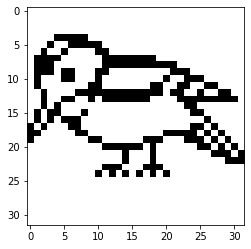

In [147]:
# Look at pattern 6 as an image
p6 = patterns[5]    # index is number - 1 !

image_p6 = p6.reshape((32, 32))
plt.imshow(image_p6, cmap='gray')  # 'cmap' sets the colormap (gray for grayscale)

In [148]:
# Learning the 3 first

dim = patterns.shape[1]

net = Hopfield(dim)

net.hebbian_learning(patterns[:3])

In [149]:
# Test recall 3 first patterns
print('Test on learned patterns')
for i, p in enumerate(patterns[:3]):
    net.asynchronous_recall(p.copy(), 5)
    if np.sum(p != net.state()) != 0:
        print('--> Error!')
        print(f'pattern : {p}')
        print(f'recall : {net.state()}')
        print('-------')
    else:
        print(f'Pattern {i} recalled')

Test on learned patterns
Pattern 0 recalled
Pattern 1 recalled
Pattern 2 recalled


Test on learned patterns
Pattern before recall


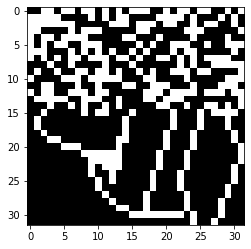

Pattern after asynchronous recall


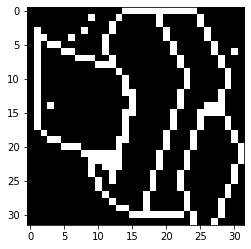

Pattern after little model recall


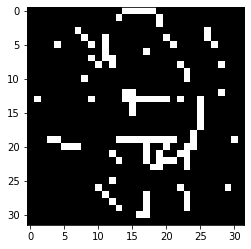

----------------------------------------------------
Pattern before recall


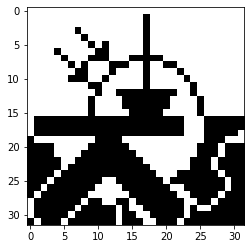

Pattern after asynchronous recall


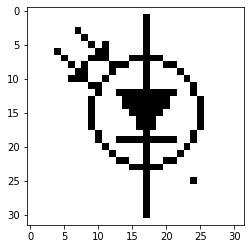

Pattern after little model recall


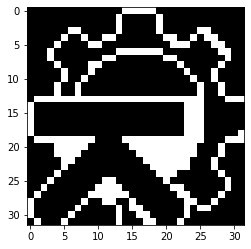

----------------------------------------------------


In [150]:
nb_LM_recall = 5
nb_iter_asynchronous_recall = 32*32*nb_LM_recall

# Test recall on patterns 10 and 11
print('Test on learned patterns')
for i, p in enumerate(patterns[9:]):
    print('Pattern before recall')
    p_reshape = p.reshape((32, 32))
    plt.imshow(p_reshape, cmap='gray') 
    plt.show()

    net.asynchronous_recall(p.copy(), nb_iter_asynchronous_recall)
    print('Pattern after asynchronous recall')
    p_reshape = net.state().reshape((32, 32))
    plt.imshow(p_reshape, cmap='gray')
    plt.show()

    net.little_model_recall(p.copy(), nb_LM_recall)
    print('Pattern after little model recall')
    p_reshape = net.state().reshape((32, 32))
    plt.imshow(p_reshape, cmap='gray')
    plt.show()

    print('----------------------------------------------------')

    

The pattern 11 is recalled into pattern 3 for asynchronous and 2 for synchronous! Does not converge for pattern 10. Global convergence faster? No if we concider than 1 iteration of Little Model is 32*32 iterations of the other model.

### 3.3 Energy

In [129]:
print(net.energy(patterns[0]))
print(net.energy(patterns[1]))
print(net.energy(patterns[2]))

print(net.energy(patterns[10]))


-1436.390625
-1362.640625
-1459.25
-170.5


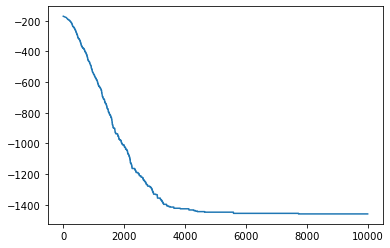

In [131]:
# On pattern 11
energies = net.asynchronous_recall(patterns[10].copy(), 10000)
plt.plot(list(range(len(energies))), energies)

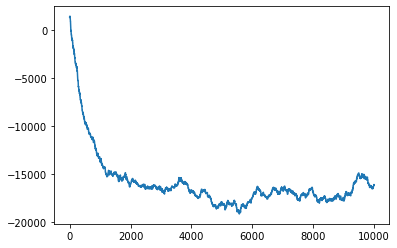

In [157]:
weight_matrix = np.random.randn(1024, 1024)
random_pattern = 2*np.random.randint(2, size=1024) - 1

test_net = Hopfield(1024, weight_matrix=weight_matrix)

# On pattern 11
energies = test_net.asynchronous_recall(random_pattern, 10000)
plt.plot(list(range(len(energies))), energies)

It explores the energy space, trying to find a local minima. As the weights are random, the energy space is chaotic.

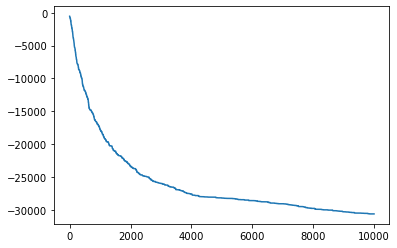

In [158]:
weight_matrix = np.random.randn(1024, 1024)
# Make it symetric
weight_matrix = 0.5 * (weight_matrix + weight_matrix.T)

random_pattern = 2*np.random.randint(2, size=1024) - 1

test_net = Hopfield(1024, weight_matrix=weight_matrix)

# On pattern 11
energies = test_net.asynchronous_recall(random_pattern, 10000)
plt.plot(list(range(len(energies))), energies)

Now the edges of the Hopfield network are bidirectional. Energy landscape is good.